In [86]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,recall_score,precision_score,confusion_matrix,classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import pickle
pd.set_option('display.max_columns', None)

In [87]:
data = pd.read_csv('/content/drive/MyDrive/ network_security_ml_project/dataset_phishing.csv')

In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

In [89]:
data['status'] = data['status'].map({'legitimate': 0, 'phishing': 1})

In [90]:


# Drop non-numeric columns (like 'url')
df = data.drop(columns=['url'], errors='ignore')

# Compute correlation matrix
correlation_matrix = df.corr()

# Get absolute correlation of features with target
correlation_with_target = correlation_matrix["status"].abs()

# Step 1: Keep features with correlation > |0.2|
selected_features = correlation_with_target[correlation_with_target > 0.2].index.tolist()

# Step 2: Drop features with correlation < |0.05|
weak_features = correlation_with_target[correlation_with_target < 0.05].index.tolist()
df = df.drop(columns=weak_features)

# Step 3: Remove Highly Correlated Features (> 0.9 correlation)
high_correlation_pairs = set()
correlation_threshold = 0.9

for i in range(len(selected_features)):
    for j in range(i + 1, len(selected_features)):
        feature1 = selected_features[i]
        feature2 = selected_features[j]

        if abs(correlation_matrix.loc[feature1, feature2]) > correlation_threshold:
            high_correlation_pairs.add((feature1, feature2))

# Keep only one feature from each highly correlated pair
features_to_remove = set()
for feature1, feature2 in high_correlation_pairs:
    # Keep the feature that has a higher correlation with the target
    if correlation_with_target[feature1] > correlation_with_target[feature2]:
        features_to_remove.add(feature2)
    else:
        features_to_remove.add(feature1)

# Final feature set after removing highly correlated features
final_selected_features = [f for f in selected_features if f not in features_to_remove]

# Print the final selected features
print("Final Selected Features:", final_selected_features)

# Keep only the selected features in the dataset
df_selected = df[final_selected_features]

df_selected.info()
# Save the cleaned dataset
#df_selected.to_csv("phishindata_selected.csv", index=False)
#print("Filtered dataset saved as 'phishindata_selected.csv'")


Final Selected Features: ['length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_qm', 'nb_eq', 'nb_slash', 'nb_www', 'ratio_digits_url', 'ratio_digits_host', 'tld_in_subdomain', 'prefix_suffix', 'shortest_word_host', 'longest_word_path', 'phish_hints', 'nb_hyperlinks', 'ratio_intHyperlinks', 'empty_title', 'domain_in_title', 'domain_age', 'google_index', 'page_rank', 'status']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   length_url           11430 non-null  int64  
 1   length_hostname      11430 non-null  int64  
 2   ip                   11430 non-null  int64  
 3   nb_dots              11430 non-null  int64  
 4   nb_qm                11430 non-null  int64  
 5   nb_eq                11430 non-null  int64  
 6   nb_slash             11430 non-null  int64  
 7   nb_www               11430 non-null  int64  
 8   ratio_d

In [91]:
from sklearn.feature_selection import mutual_info_classif

# Final feature set after correlation filtering
filtered_features = [f for f in selected_features if f not in features_to_remove]

# Step 4: Apply Mutual Information for Feature Selection
X = df[filtered_features]  # Features
y = df["status"]           # Target

mi_scores = mutual_info_classif(X, y, discrete_features='auto')

# Convert MI scores into a DataFrame
mi_df = pd.DataFrame({"Feature": filtered_features, "MI_Score": mi_scores})
mi_df = mi_df.sort_values(by="MI_Score", ascending=False)

# Select the top N features based on MI
top_n = 20  # You can adjust this
final_selected_features = mi_df.head(top_n)["Feature"].tolist()

# Print the final selected features
print("Final Selected Features:", final_selected_features)

# Keep only the selected features in the dataset
df_selected = df[final_selected_features]
df_selected.info()

# Save the cleaned dataset
# df_selected.to_csv("phishindata_selected_mi.csv", index=False)
# print("Filtered dataset saved as 'phishindata_selected_mi.csv'")

Final Selected Features: ['status', 'google_index', 'domain_age', 'ratio_intHyperlinks', 'nb_hyperlinks', 'page_rank', 'nb_www', 'longest_word_path', 'ratio_digits_url', 'phish_hints', 'shortest_word_host', 'length_url', 'domain_in_title', 'ip', 'length_hostname', 'nb_dots', 'ratio_digits_host', 'nb_qm', 'nb_eq', 'nb_slash']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   status               11430 non-null  int64  
 1   google_index         11430 non-null  int64  
 2   domain_age           11430 non-null  int64  
 3   ratio_intHyperlinks  11430 non-null  float64
 4   nb_hyperlinks        11430 non-null  int64  
 5   page_rank            11430 non-null  int64  
 6   nb_www               11430 non-null  int64  
 7   longest_word_path    11430 non-null  int64  
 8   ratio_digits_url     11430 non-null  float64
 9   phish_hin

In [92]:
from sklearn.feature_selection import VarianceThreshold

X = df_selected.drop('status', axis = 1)  # Features
y = df["status"]           # Target

selector = VarianceThreshold(threshold=0.03)  # Remove features with variance < 1%
X_new = selector.fit_transform(X)

selected_features = X.columns[selector.get_support()]
print("Remaining Features:", selected_features)

Remaining Features: Index(['google_index', 'domain_age', 'ratio_intHyperlinks', 'nb_hyperlinks',
       'page_rank', 'nb_www', 'longest_word_path', 'phish_hints',
       'shortest_word_host', 'length_url', 'domain_in_title', 'ip',
       'length_hostname', 'nb_dots', 'nb_qm', 'nb_eq', 'nb_slash'],
      dtype='object')


In [93]:
final_dataset = data[selected_features]

In [94]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   google_index         11430 non-null  int64  
 1   domain_age           11430 non-null  int64  
 2   ratio_intHyperlinks  11430 non-null  float64
 3   nb_hyperlinks        11430 non-null  int64  
 4   page_rank            11430 non-null  int64  
 5   nb_www               11430 non-null  int64  
 6   longest_word_path    11430 non-null  int64  
 7   phish_hints          11430 non-null  int64  
 8   shortest_word_host   11430 non-null  int64  
 9   length_url           11430 non-null  int64  
 10  domain_in_title      11430 non-null  int64  
 11  ip                   11430 non-null  int64  
 12  length_hostname      11430 non-null  int64  
 13  nb_dots              11430 non-null  int64  
 14  nb_qm                11430 non-null  int64  
 15  nb_eq                11430 non-null 

In [95]:
final_dataset.head()

,google_index,domain_age,ratio_intHyperlinks,nb_hyperlinks,page_rank,nb_www,longest_word_path,phish_hints,shortest_word_host,length_url,domain_in_title,ip,length_hostname,nb_dots,nb_qm,nb_eq,nb_slash
0,1,-1,0.529412,17,4,1,6,0,3,37,0,0,19,3,0,0,3
1,1,5767,0.966667,30,2,0,32,0,19,77,1,1,23,1,0,0,5
2,1,4004,1.000000,4,0,0,17,0,3,126,1,1,50,4,1,3,5
3,0,-1,0.973154,149,3,0,0,0,5,18,1,0,11,2,0,0,2
4,0,8175,0.470588,102,6,1,11,0,3,55,0,0,15,2,0,0,5


Top 10 Important Features:
                Feature  Importance
0          google_index    0.336165
4             page_rank    0.163615
3         nb_hyperlinks    0.151140
5                nb_www    0.067171
6     longest_word_path    0.045956
1            domain_age    0.045802
2   ratio_intHyperlinks    0.039077
7           phish_hints    0.032666
9            length_url    0.022899
12      length_hostname    0.018100


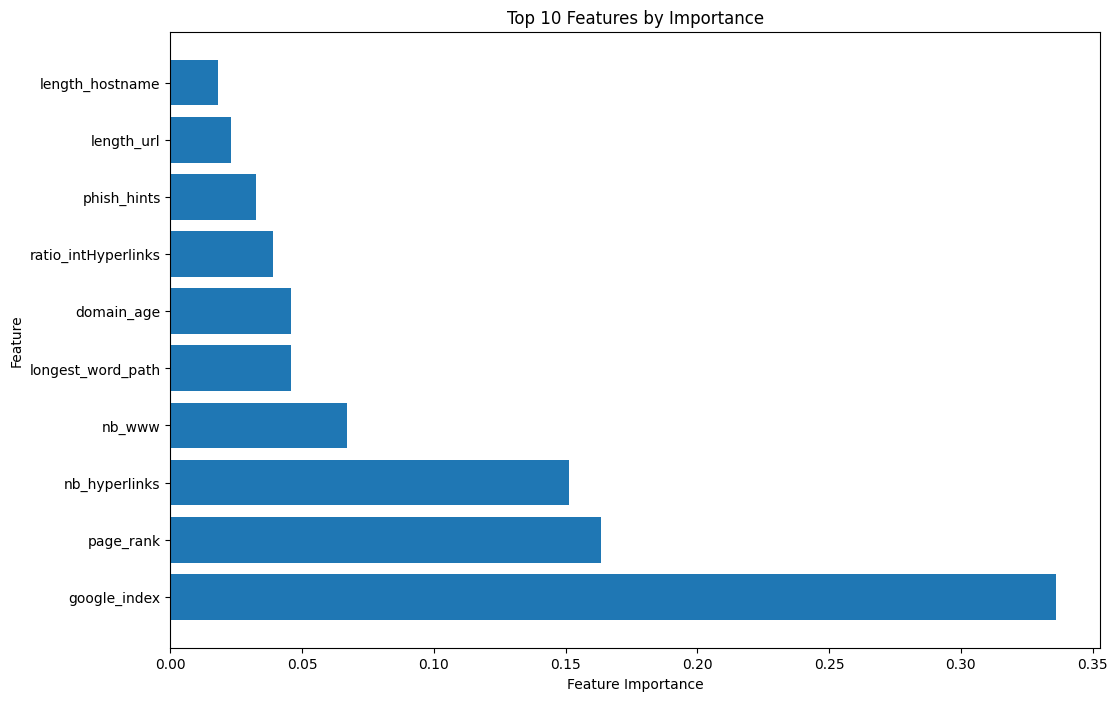

Train Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4286
           1       0.97      0.97      0.97      4286

    accuracy                           0.97      8572
   macro avg       0.97      0.97      0.97      8572
weighted avg       0.97      0.97      0.97      8572

Test Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1429
           1       0.94      0.96      0.95      1429

    accuracy                           0.95      2858
   macro avg       0.95      0.95      0.95      2858
weighted avg       0.95      0.95      0.95      2858



In [96]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

X = data[final_dataset.columns]
y = data['status']

# Step 2: Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# Step 3: Feature Scaling (standardize the features)
scaler = StandardScaler()

# Fit scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Initialize Random Forest model with regularization
rf_model = RandomForestClassifier(
    n_estimators=100,          # Number of trees
    max_depth=10,              # Maximum depth of trees
    min_samples_split=10,      # Minimum samples to split node
    min_samples_leaf=5,        # Minimum samples at leaf node
    max_features='sqrt',       # Limit the number of features considered for split
    bootstrap=True,            # Use bootstrap sampling
    random_state=42            # For reproducibility
)

# Step 5: Train the model with scaled data
rf_model.fit(X_train_scaled, y_train)

# Step 6: Get feature importance
feature_importance = rf_model.feature_importances_

# Step 7: Create a DataFrame to hold the feature names and their importance
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importance
})

# Step 8: Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 9: Display the top 10 important features
print("Top 10 Important Features:")
print(importance_df.head(10))

# Step 10: Plot Feature Importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features by Importance')
plt.show()

# Step 11: Evaluate the model
y_train_pred = rf_model.predict(X_train_scaled)
y_test_pred = rf_model.predict(X_test_scaled)

print("Train Classification Report:")
print(classification_report(y_train, y_train_pred))

print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.25, random_state=42, stratify=y)

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss", random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Evaluate model performance
print("=== Train Classification Report ===")
print(classification_report(y_train, y_train_pred))

print("=== Test Classification Report ===")
print(classification_report(y_test, y_test_pred))

# Print accuracy scores
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


In [85]:
import plotly.graph_objects as go
from sklearn.model_selection import learning_curve

# Generate learning curve data
train_sizes, train_scores, test_scores = learning_curve(rf_model, X, y, cv=5, n_jobs=-1, train_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# Mean train and test scores for each training size
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

# Create traces for the learning curve plot
train_trace = go.Scatter(
    x=train_sizes,
    y=train_mean,
    mode='lines',
    name='Train',
    line=dict(color='blue')
)

test_trace = go.Scatter(
    x=train_sizes,
    y=test_mean,
    mode='lines',
    name='Test',
    line=dict(color='red')
)

# Define layout for the plot
layout = go.Layout(
    title='Learning Curve',
    xaxis=dict(title='Training Set Size'),
    yaxis=dict(title='Accuracy'),
    showlegend=True
)

# Create the figure and plot
fig = go.Figure(data=[train_trace, test_trace], layout=layout)
fig.show()

In [108]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

X = data[final_dataset.columns]
y = data['status']

# Step 2: Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Feature Scaling (standardize the features)
scaler = StandardScaler()

# Fit scaler on the training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: Initialize the models

# 4.1 XGBoost Model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,         # Number of trees
    max_depth=10,             # Maximum depth of trees
    learning_rate=0.1,        # Learning rate
    random_state=42
)

# 4.2 Ridge Classifier
ridge_model = RidgeClassifier(alpha=1.0)

# 4.3 Random Forest Model
rf_model = RandomForestClassifier(
    n_estimators=100,          # Number of trees
    max_depth=10,              # Maximum depth of trees
    min_samples_split=10,      # Minimum samples to split node
    min_samples_leaf=5,        # Minimum samples at leaf node
    max_features='sqrt',       # Limit the number of features considered for split
    bootstrap=True,            # Use bootstrap sampling
    random_state=42            # For reproducibility
)

# 4.4 Voting Classifier (Ensemble of Random Forest, XGBoost, Ridge Classifier)
voting_model = VotingClassifier(
    estimators=[('rf', rf_model), ('ridge', ridge_model)],
    voting='hard'  # 'hard' for majority voting, 'soft' for probability-based voting
)

# Step 5: Train the models

# XGBoost model
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=42
)

# Fit the model
xgb_model.fit(X_train_scaled, y_train)


# Train Ridge Classifier
ridge_model.fit(X_train_scaled, y_train)

# Train Random Forest model
rf_model.fit(X_train_scaled, y_train)

# Train Voting Classifier
voting_model.fit(X_train_scaled, y_train)

# Step 6: Make predictions
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

y_train_pred_ridge = ridge_model.predict(X_train_scaled)
y_test_pred_ridge = ridge_model.predict(X_test_scaled)

y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

y_train_pred_voting = voting_model.predict(X_train_scaled)
y_test_pred_voting = voting_model.predict(X_test_scaled)

# Step 7: Evaluate the models
print("XGBoost Model - Train Classification Report:")
print(classification_report(y_train, y_train_pred_xgb))

print("XGBoost Model - Test Classification Report:")
print(classification_report(y_test, y_test_pred_xgb))

print("Ridge Classifier - Train Classification Report:")
print(classification_report(y_train, y_train_pred_ridge))

print("Ridge Classifier - Test Classification Report:")
print(classification_report(y_test, y_test_pred_ridge))

print("Random Forest Model - Train Classification Report:")
print(classification_report(y_train, y_train_pred_rf))

print("Random Forest Model - Test Classification Report:")
print(classification_report(y_test, y_test_pred_rf))

print("Voting Classifier - Train Classification Report:")
print(classification_report(y_train, y_train_pred_voting))

print("Voting Classifier - Test Classification Report:")
print(classification_report(y_test, y_test_pred_voting))


XGBoost Model - Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4572
           1       1.00      1.00      1.00      4572

    accuracy                           1.00      9144
   macro avg       1.00      1.00      1.00      9144
weighted avg       1.00      1.00      1.00      9144

XGBoost Model - Test Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1143
           1       0.95      0.97      0.96      1143

    accuracy                           0.96      2286
   macro avg       0.96      0.96      0.96      2286
weighted avg       0.96      0.96      0.96      2286

Ridge Classifier - Train Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4572
           1       0.91      0.91      0.91      4572

    accuracy                           0.91  

In [109]:
pip install mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 637.5/637.5 kB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.0 MB/s eta 0:00:00


In [1]:
import mlflow
import mlflow.sklearn
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import numpy as np
import os
import dagshub

In [ ]:
# Define hyperparameters to search
param_dist = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Assuming df and y are your features and target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Setup RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of random combinations to try
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


In [ ]:

# Start MLflow tracking
with mlflow.start_run():

    # Fit the model using randomized search
    random_search.fit(X_train_scaled, y_train)

    # Log the best hyperparameters and model
    best_params = random_search.best_params_
    mlflow.log_params(best_params)

    # Get the best model
    best_rf_model = random_search.best_estimator_

    # Make predictions and evaluate
    y_train_pred = best_rf_model.predict(X_train_scaled)
    y_test_pred = best_rf_model.predict(X_test_scaled)

    # Log the classification report as a metric
    mlflow.log_metric("train_accuracy", best_rf_model.score(X_train_scaled, y_train))
    mlflow.log_metric("test_accuracy", best_rf_model.score(X_test_scaled, y_test))

    print("Best Hyperparameters:", best_params)
    print("Random Forest - Train Classification Report:")
    print(classification_report(y_train, y_train_pred))

    print("Random Forest - Test Classification Report:")
    print(classification_report(y_test, y_test_pred))

    # Log the model
    mlflow.sklearn.log_model(best_rf_model, "random_forest_model")